In [1]:
#data is taken from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE189425 and subsetted for the natural embryo at E8.5

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import scvelo as scv
import scrublet as scr
import scanpy.external as sce
import numpy as np
import pandas as pd
import scanpy as sc
import cellrank as cr
import phate
import bbknn
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.sparse import csr_matrix



scv.logging.print_version()
scv.settings.verbosity = 3  
scv.settings.set_figure_params('scvelo') 

Running scvelo 0.2.4 (python 3.9.7) on 2023-08-09 07:44.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


In [2]:
## load data object, this object was integrated with sciRNA-seq3 and the 5EU-seq data in R using Seurat
adata_m = sc.read("210922_indrop_E85_velo.h5ad")

In [4]:
## load colour palette
paletten=['#997D87',
'#B79762',
'#3B5DFF',
'#004D43',
'#7A4900',
'#1B4400',
'#4FC601',
'#1CE6FF',
'#FF2F80',
'#8FB0FF',
'#4A3B53',
'#FF4A46',
'#0000A6',
'#008941',
'#61615A',
'#FF34FF',
'#63FFAC',
'#FFDBE5',
'#5A0007',
'#6A3A4C',
'#809693',
'#006FA6',
'#FFFF00',
'#A30059']

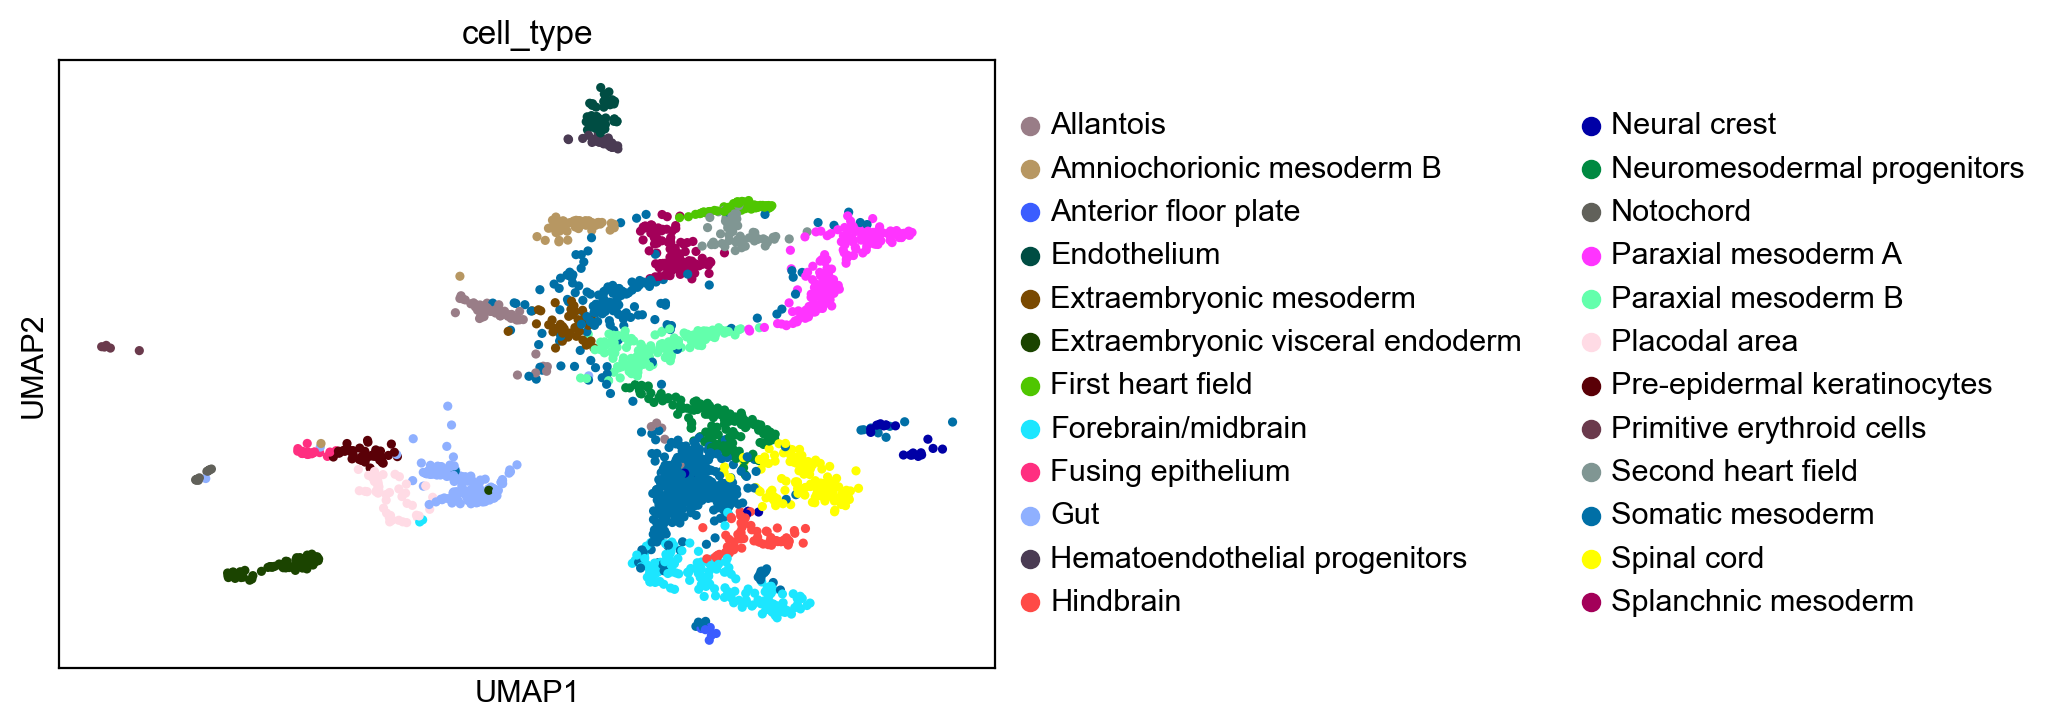

In [5]:
sc.pl.umap(adata_m, color= "cell_type", palette =paletten)

computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:06) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/6 cores)


  0%|          | 0/2745 [00:00<?, ?cells/s]

/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


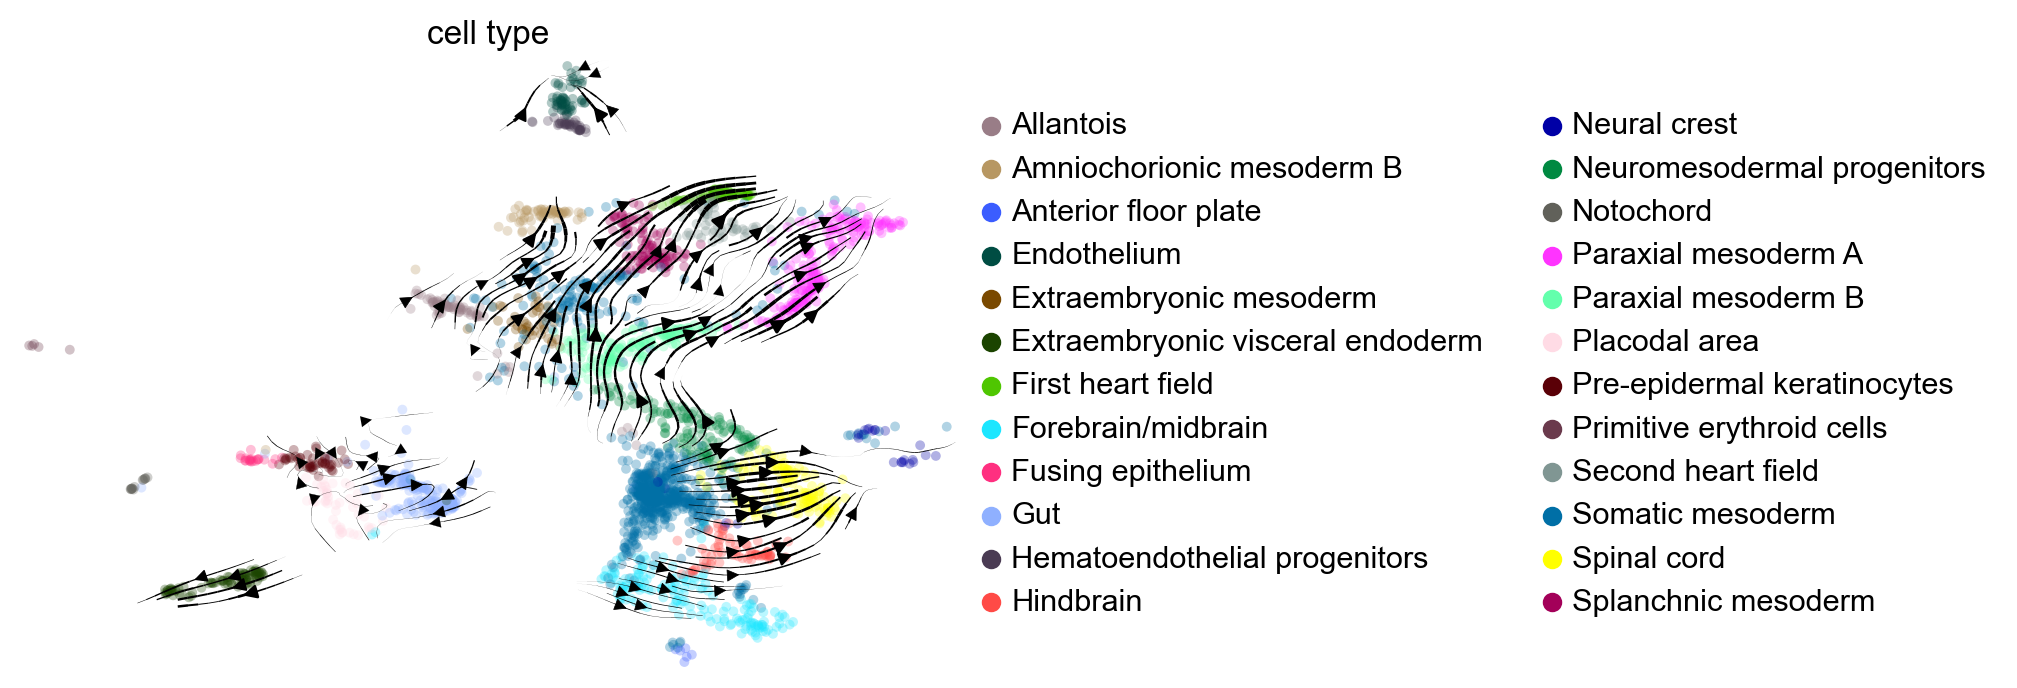

In [8]:
## velocity computation in stochastic mode
scv.pp.filter_and_normalize(adata_m)
scv.pp.moments(adata_m)
scv.tl.velocity(adata_m, mode='stochastic')
scv.tl.velocity_graph(adata_m)

scv.pl.velocity_embedding_stream(adata_m, basis='umap', color=["cell_type"],palette = paletten, legend_loc='right_margin',size=50,density=3)

In [9]:
##subsample to match sample size for 5EU-seq object
sc.pp.subsample(adata_m, n_obs=936)

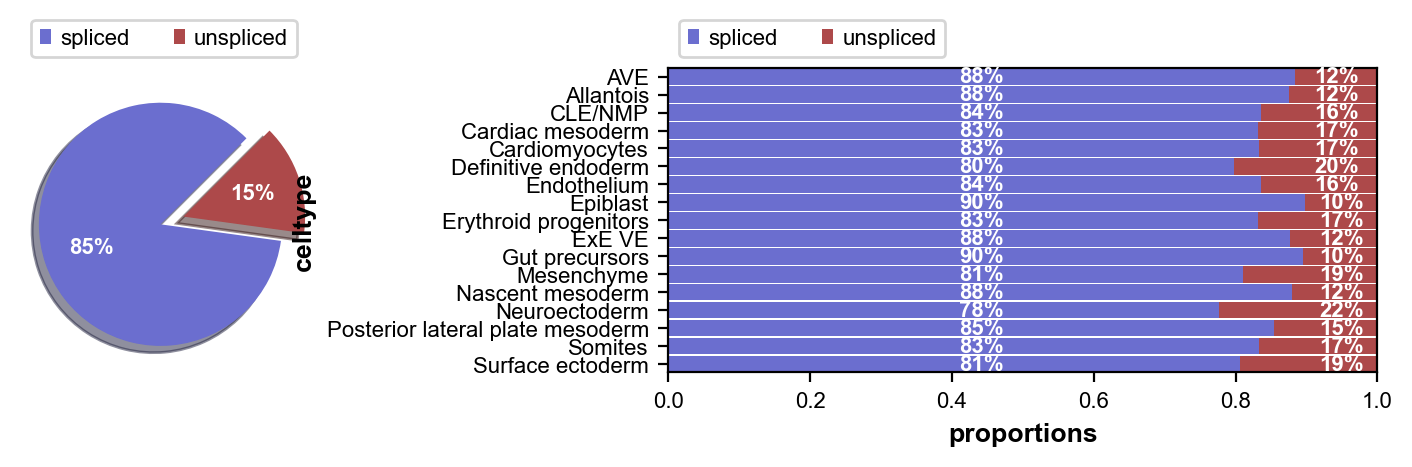

In [10]:
##plot proportions of unspliced and spliced
scv.pl.proportions(adata_m, groupby='celltype')

In [11]:
##subset  to object with NMP differentiation cell types
adata_NMP  = adata_m[(adata_m.obs["cell_type"]=="Neuromesodermal progenitors") | (adata_m.obs["cell_type"]=="Paraxial mesoderm B") |(adata_m.obs["cell_type"]=="Paraxial mesoderm A") | 
                  (adata_m.obs["cell_type"]=="Spinal cord") ,] 

In [12]:
##subset to match 5EU-seq data size
sc.pp.subsample(adata_NMP, n_obs=109)

In [13]:
##compute velocity dynamics for the vector
scv.tl.recover_dynamics(adata_NMP)

recovering dynamics (using 1/6 cores)


  0%|          | 0/320 [00:00<?, ?gene/s]

    finished (0:00:17) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [14]:
scv.tl.latent_time(adata_NMP,root_key="Neuromesodermal progenitors")

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [15]:
sc.pp.neighbors(adata_NMP)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [16]:
##compute cellrank terminal and initial stages
cr.tl.terminal_states(adata_NMP, cluster_key="cell_type", weight_connectivities=0.5,n_states=2, n_cells=20)

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/2091760268.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata_NMP, cluster_key="cell_type", weight_connectivities=0.5,n_states=2, n_cells=20)
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/109 [00:00<?, ?cell/s]

  0%|          | 0/109 [00:00<?, ?cell/s]

In [17]:
cr.tl.initial_states(adata_NMP, cluster_key="cell_type", n_cells=30,
    softmax_scale=4,
    n_states=1)

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/4142161930.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata_NMP, cluster_key="cell_type",    n_cells=30,
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/cellrank/tl/_init_term_states.py:156: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = transition_matrix(


  0%|          | 0/109 [00:00<?, ?cell/s]

In [18]:
##compute lineages
cr.tl.lineages(adata_NMP)

Defaulting to `'gmres'` solver.


/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/4230593544.py:2: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata_NMP)


  0%|          | 0/2 [00:00<?, ?/s]

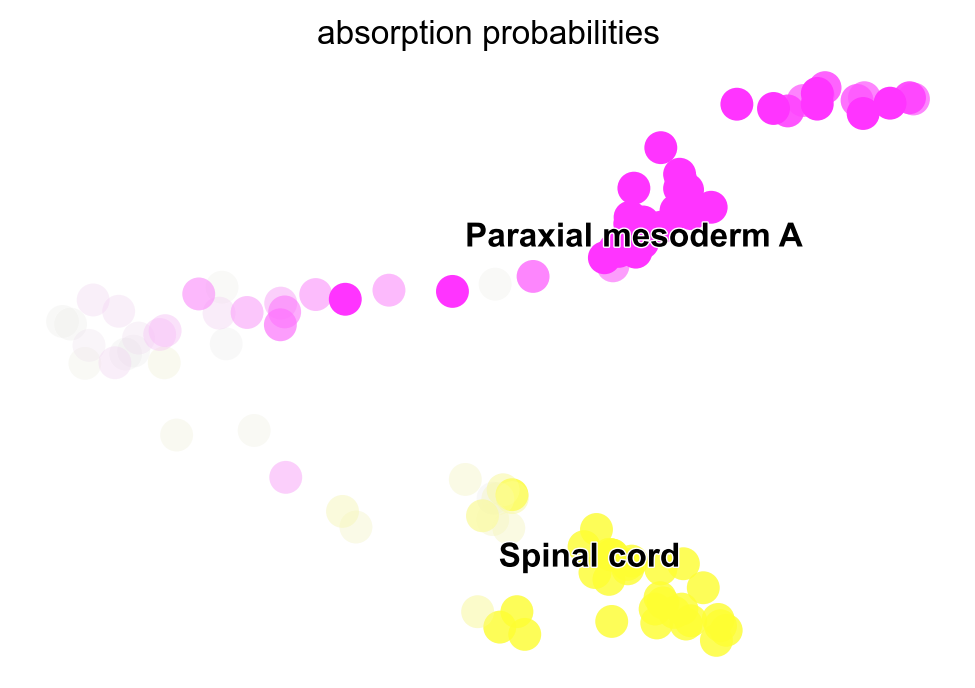

In [19]:
cr.pl.lineages(adata_NMP)

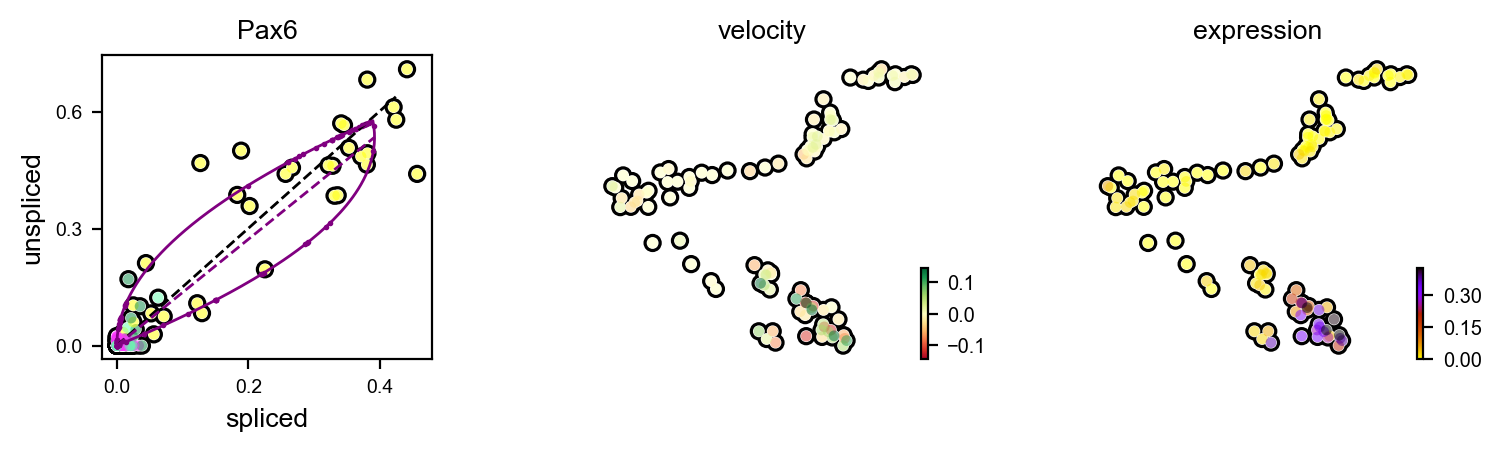

In [20]:
##split induction and repression
scv.pl.velocity(adata_NMP, ['Pax6'], color = ["cell_type"], ncols=2, add_outline=True,size =60)

In [21]:
##isolate endothelium trajetory celltypes
adata_e = adata_m[(adata_m.obs["cell_type"]=="Hematoendothelial progenitors") |(adata_m.obs["cell_type"]=="Endothelium") ,] 

In [22]:
##match 5EU-seq dataset size
sc.pp.subsample(adata_e, n_obs=33)

In [24]:
scv.tl.recover_dynamics(adata_e)

recovering dynamics (using 1/6 cores)


  0%|          | 0/320 [00:00<?, ?gene/s]

    finished (0:00:13) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/joachimdejonghe/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


In [28]:
cr.tl.terminal_states(adata_e, cluster_key="cell_type",n_cells=8, n_states=1)

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/2040193473.py:1: DeprecationWarning: `cellrank.tl.terminal_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.terminal_states(adata_e, cluster_key="cell_type",n_cells=8, n_states=1)


In [30]:
cr.tl.initial_states(adata_e, cluster_key="cell_type", n_cells=8,
    softmax_scale=4,
    n_states=1)
cr.tl.lineages(adata_e)

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/3656091053.py:1: DeprecationWarning: `cellrank.tl.initial_states` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.initial_states(adata_e, cluster_key="cell_type", n_cells=8,
/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/3656091053.py:4: DeprecationWarning: `cellrank.tl.lineages` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineages(adata_e)


  0%|          | 0/1 [00:00<?, ?/s]

In [31]:
cr.tl.lineage_drivers(adata_e,lineage ="Endothelium")

/var/folders/kp/wyyqg6415vq0dqr0n9bqbj540000gn/T/ipykernel_40830/4238583434.py:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata_e,lineage ="Endothelium")


,Endothelium_corr,Endothelium_pval,Endothelium_qval,Endothelium_ci_low,Endothelium_ci_high
Kidins220,0.742403,1.648081e-07,NaN,0.535606,0.865196
Adgrf5,0.730042,3.631248e-07,NaN,0.516077,0.858248
Oxr1,0.699946,2.035966e-06,NaN,0.469443,0.841133
Parvb,0.694803,2.666354e-06,NaN,0.461600,0.838179
Exosc2,0.694314,2.734635e-06,NaN,0.460857,0.837898
...,...,...,...,...,...
3110006O06Rik,NaN,NaN,NaN,NaN,NaN
Gm49448,NaN,NaN,NaN,NaN,NaN
Gm32431,NaN,NaN,NaN,NaN,NaN
Gm30251,NaN,NaN,NaN,NaN,NaN
